## Deep neural network with my own dataset

In [1]:
import tensorflow as tf
import glob
import numpy as np
import matplotlib.pyplot as plt
from scipy.misc import imresize, imread
import random
from random import randint

plt.style.use('ggplot')

In [2]:
#The most essential components to build a deep neural network consist of a feed forward neural network,
#a cost function followed by a function that minimizes the cost (backpropagation), 
#and for training the network we combine the feed forward network with the backpropagation in an epoch.
#An epoch is a complete pass through a given dataset. 

#This dataset consist of both big and small letters from A-J

In [3]:
classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']

data_train = []
labels_train = []

data_test = []
labels_test = []

data_trainset = ['A/*', 'B/*', 'C/*','D/*','E/*', 'F/*', 'G/*', 'H/*', 'I/*', 'J/*']

for label in range(len(classes)):
    print('Currently loading class: ', classes[label])
    idx = 0
    for filename in glob.glob(data_trainset[label]):

        try:
            img = imread(filename)

            if(len(img.shape) != 2):
                break

            img = img.astype(np.float32)
            img = imresize(img, (28,28))

            if(idx < 50):
                idx += 1
                data_test.append(img)
                labels_test.append(label)
            else:
                data_train.append(img)
                labels_train.append(label)
        except OSError:
            break
print('DONE loading!')

Currently loading class : A
Currently loading class : B
Currently loading class : C
Currently loading class : D
Currently loading class : E
Currently loading class : F
Currently loading class : G
Currently loading class : H
Currently loading class : I
Currently loading class : J
DONE loading!


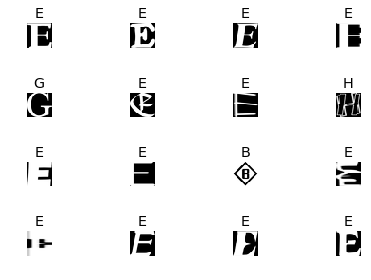

In [4]:
#plotting some examples from the dataset
def plot_grid_example(names, data, labels):
    plt.figure()
    m,n = 4,4
    random_array = random.sample(range(len(data)), m*n)
    
    for i in range(m*n):
        plt.subplot(m,n,i+1)
        j = random_array[i]
        plt.title(names[labels[j]])
        img = data[j]
        plt.imshow(img, cmap = 'Greys_r')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_grid_example(classes, data_train, labels_train)

In [5]:
#Tensorflow requires that the data is represented in an array,
#with datatype as either float32 or float64
data_train = np.asarray(data_train, dtype = np.float32)
labels_train = np.asarray(labels_train, dtype = np.float32)
data_test = np.asarray(data_test, dtype = np.float32)
labels_test = np.asarray(labels_test, dtype = np.float32)

image_size = 28
num_labels_train = len(classes)
num_channels = 1 # grayscale

def reformat(data_set, label_set):
    #the data set is shaped into a suitable shape
    data_set = data_set.reshape(
    (-1, image_size, image_size, num_channels)).astype(np.float32)
    #the labels are now getting one-hot encoded
    label_set = (np.arange(num_labels_train) == label_set[:,None]).astype(np.float32)
    return data_set, label_set

data_train, labels_train = reformat(data_train, labels_train)
data_test, labels_test = reformat(data_test, labels_test)

In [6]:
#Parameters for the network
n_neurons_hl1 = 500
n_neurons_hl2 = 500
n_neurons_hl3 = 500

n_classes = len(classes)
batch_size = 100
costs = [] #for plotting costs


x = tf.placeholder(dtype = tf.float32, shape = [None, 28*28])
y = tf.placeholder(dtype = tf.float32)

#we need to reshape the entire test dataset, since the shape of placeholder 'x' is determined
data_test = np.reshape(data_test, (-1, 28*28))

In [7]:
def neural_network_model(data_train):
    hidden_1_layer = {'weights': tf.Variable(tf.random_normal([28*28, n_neurons_hl1])),
                        'biases': tf.Variable(tf.random_normal([n_neurons_hl1]))}

    hidden_2_layer = {'weights': tf.Variable(tf.random_normal([n_neurons_hl1, n_neurons_hl2])),
                        'biases': tf.Variable(tf.random_normal([n_neurons_hl2]))}

    hidden_3_layer = {'weights': tf.Variable(tf.random_normal([n_neurons_hl2, n_neurons_hl3])),
                        'biases': tf.Variable(tf.random_normal([n_neurons_hl3]))}

    output_layer = {'weights': tf.Variable(tf.random_normal([n_neurons_hl3, n_classes])),
                        'biases': tf.Variable(tf.random_normal([n_classes]))}

    #(input_data_train * weights) + biases

    l1 = tf.add(tf.matmul(data_train, hidden_1_layer['weights']), hidden_1_layer['biases'] )
    l1 = tf.nn.relu(l1)

    l2 = tf.add(tf.matmul(l1, hidden_2_layer['weights']), hidden_2_layer['biases'] )
    l2 = tf.nn.relu(l2)

    l3 = tf.add(tf.matmul(l2, hidden_3_layer['weights']), hidden_3_layer['biases'] )
    l3 = tf.nn.relu(l3)

    output= tf.add(tf.matmul(l3, output_layer['weights']), output_layer['biases'] )

    return output

def train_neural_network(x):
    prediction = neural_network_model(x)
    cost = tf.reduce_mean( tf.nn.softmax_cross_entropy_with_logits(logits = prediction,
                                                                   labels = y))
    optimizer = tf.train.AdamOptimizer().minimize(cost)
    data_train_test = data_train
    total_epochs = 10    

    with tf.Session() as sess:

        sess.run(tf.global_variables_initializer())
        batch_size = len(data_train) // 200
        for epoch in range(total_epochs):
            epoch_loss = 0
            for i in range(0, len(data_train), batch_size):
                #randomizes the batch
                indices = np.random.choice(data_train.shape[0], batch_size)
                batch_data_train = data_train[indices]
                batch_labels_train = labels_train[indices]
                
                #needs to reshape every loop, since the 
                #placeholder 'x' requires a specific shape
                batch_data_train = np.reshape(batch_data_train, (-1, 28*28))
                
                _, c = sess.run([optimizer, cost], feed_dict = {x: batch_data_train,
                                                                y: batch_labels_train})
                
                epoch_loss += c
            costs.append(c)
            print('Total loss on epoch ', epoch +1, '/' , total_epochs, ": ", epoch_loss)
    
        correct = tf.equal(tf.argmax(prediction,1), tf.argmax(y,1))
        accuracy = tf.reduce_mean(tf.cast(correct, dtype = tf.float32))
        print('Accuraccy when testing with a new dataset: ', accuracy.eval({x:data_test, y :labels_test}))

In [8]:
train_neural_network(x)

Total loss on epoch  1 / 10 :  205660356.016
Total loss on epoch  2 / 10 :  73004281.5312
Total loss on epoch  3 / 10 :  48847716.418
Total loss on epoch  4 / 10 :  35917380.6191
Total loss on epoch  5 / 10 :  24856464.918
Total loss on epoch  6 / 10 :  19729656.0039
Total loss on epoch  7 / 10 :  14107723.8184
Total loss on epoch  8 / 10 :  11564646.2129
Total loss on epoch  9 / 10 :  9354936.4939
Total loss on epoch  10 / 10 :  7502177.54968
Accuraccy when testing with a new dataset:  0.758


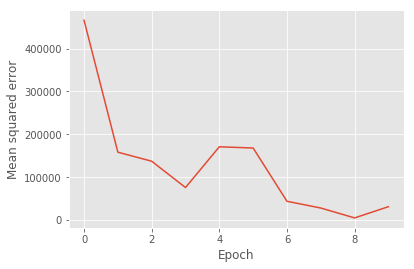

In [9]:
def plot_costs(costs = costs):
    plt.plot(costs)
    plt.ylabel("Mean squared error")
    plt.xlabel("Epoch")
    plt.show()

plot_costs()